In [2]:
import os

!pip install -q nibabel
#print(nibabel)
!pip  install -q --extra-index-url https://download.pytorch.org/whl/cu117 torch==2.0.0 torchvision==0.15.0 omegaconf torchmetrics==0.10.3 fvcore iopath 
#!pip  install --extra-index-url https://download.pytorch.org/whl/cu117 torch==2.0.0 torchvision==0.15.0 omegaconf torchmetrics==0.10.3 fvcore iopath xformers==0.0.18 submitit
print("--extra-index-url https://download.pytorch.org/whl/cu117 torch==2.0.0 torchvision==0.15.0 omegaconf torchmetrics==0.10.3 fvcore iopath ")
!pip install "numpy<2.0"


--extra-index-url https://download.pytorch.org/whl/cu117 torch==2.0.0 torchvision==0.15.0 omegaconf torchmetrics==0.10.3 fvcore iopath 
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4


In [3]:
#xformers should not be installed!!!!!!!
!pip uninstall xformers -y

In [4]:
import sys
sys.path.insert(0, "/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader6")


In [5]:
# os.environ['PYTHONPATH'] = "/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader6"
import os
import torch
from functools import partial
from dinov2.models.vision_transformer import vit_base, DinoVisionTransformer
from dinov2.layers import Mlp, PatchEmbed, SwiGLUFFNFused, MemEffAttention, NestedTensorBlock as Block
# Initialize ViT-Base model with patch size 16 and any additional parameters

import torch
from dinov2.models.vision_transformer import vit_base
from dinov2.models.vision_transformer import DinoVisionTransformer

import numpy as np
    
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader6/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader6/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader6/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


1. The Teacher Model Includes Both backbone and dino_head: The presence of backbone and dino_head keys in the checkpoint means that the model’s head and backbone components are saved separately. You might need to handle each part separately when loading weights.

2. Mixed Precision Settings: If the checkpoint was trained with mixed precision, ensure your model and environment support loading fp16 weights. This might involve setting up a mixed-precision environment with torch.cuda.amp.

3. Specific Layers: The configuration specifies various heads (e.g., dino_head, ibot_head). If your model does not have these components, remove the related keys from the state dictionary or update your model definition to include them.

In [6]:
os.environ['PYTHONPATH'] = "/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader5"

# checkpoint_path = '/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader5/output_dir/448_192_B1and2__/eval/training_169999/teacher_checkpoint.pth'
# checkpoint_path = "/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader5/output_dir/448_192_B1to10_B2/eval/training_59999/teacher_checkpoint.pth"
checkpoint_path = "/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader6/output_dir/448_192_all_B6/eval/training_247499/teacher_checkpoint.pth"
checkpoint_path = "/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader5/output_dir/448_192_all_17M_B8/eval/training_449999/teacher_checkpoint.pth"
#checkpoint_path = "/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader6/output_dir/448_192_all17M_B8/eval/training_329999/teacher_checkpoint.pth"
checkpoint_path = "/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader6/output_dir/448_192_all14_17M_P32_B8/eval/training_314999/teacher_checkpoint.pth"
#checkpoint_path = "/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader6/output_dir/448_192_all14_17M_P32-noif_B8/eval/training_14999/teacher_checkpoint.pth"
#checkpoint_path = "/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader6/output_dir/448_192_all17M_B8/eval/training_539999/teacher_checkpoint.pth"

patch_size = 32
n_patch = 14 if patch_size == 32 else 28

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(checkpoint_path, map_location=device)
print(checkpoint.keys())
teacher_weights = checkpoint["teacher"]
teacher_weights_cleaned = {k.replace("backbone.", ""): v for k, v in teacher_weights.items()}
# Assuming you have imported vit_base and are creating a model instance
model_ct = DinoVisionTransformer(
        img_size=448,
        patch_size=patch_size,
        drop_path_rate=0.0,
        block_chunks=1,
        drop_path_uniform=True,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4,
        block_fn=partial(Block, attn_class=MemEffAttention),
        num_register_tokens=5,
        init_values = 1.0e-05,
    ).to(device)

model_ct.load_state_dict(teacher_weights_cleaned, strict=False)
model_ct.eval()

dict_keys(['teacher'])


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): BlockChunk(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (ls2): L

1. In ViTs, the transformer encoder consists of multiple blocks (self-attention layers, MLP layers, etc.), so **models like DINO typically define them under model.blocks**.
The blocks attribute is a list (torch.nn.ModuleList) of transformer layers that make up the core of the model.

Is blocks an attribute in all models?
🔹 No, blocks is not a universal PyTorch attribute.


In [8]:
model_ct.blocks[-1]

BlockChunk(
  (0-11): 12 x NestedTensorBlock(
    (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (attn): MemEffAttention(
      (qkv): Linear(in_features=768, out_features=2304, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=768, out_features=768, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (ls1): LayerScale()
    (drop_path1): Identity()
    (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (act): GELU(approximate='none')
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (ls2): LayerScale()
    (drop_path2): Identity()
  )
)

In [9]:
model_ct.blocks[-1][-1]

NestedTensorBlock(
  (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (attn): MemEffAttention(
    (qkv): Linear(in_features=768, out_features=2304, bias=True)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=768, out_features=768, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (ls1): LayerScale()
  (drop_path1): Identity()
  (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU(approximate='none')
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
  (ls2): LayerScale()
  (drop_path2): Identity()
)

In [10]:
model_ct.blocks[-1][-1].attn

MemEffAttention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)

# Model Summary

In [11]:
!pip install torchinfo
from torchinfo import summary
model = model_ct # Replace this with your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(
    model_ct, 
    input_size=(1, 3, 448, 448),  # Batch size of 1, change according to your input shape
    col_names=["input_size", "output_size", "num_params", "kernel_size"], 
    depth=3  # Controls the level of depth to display in nested modules
)

  Using cached torchinfo-1.8.0-py3-none-any.whl.metadata (21 kB)
Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape
DinoVisionTransformer                         [1, 3, 448, 448]          [1, 768]                  156,672                   --
├─PatchEmbed: 1-1                             [1, 3, 448, 448]          [1, 196, 768]             --                        --
│    └─Conv2d: 2-1                            [1, 3, 448, 448]          [1, 768, 14, 14]          2,360,064                 [32, 32]
│    └─Identity: 2-2                          [1, 196, 768]             [1, 196, 768]             --                        --
├─ModuleList: 1-2                             --                        --                        --                        --
│    └─BlockChunk: 2-3                        [1, 202, 768]             [1, 202, 768]             --                        --
│    │    └─NestedTensorBlock: 3-1            [1, 202, 768]             [1, 202, 768]          

### blocks[-1] refers to the last BlockChunk, which contains 12 NestedTensorBlock layers.

### model_ct.blocks[-1][-1] accesses the 12th (last) NestedTensorBlock inside that BlockChunk.

blocks[-1] only refers to the last set of transformer blocks, not the LayerNorm that comes after the entire transformer stack.
The final LayerNorm (before output) can be accessed separately using:

model_ct.norm

In [12]:
# os.listdir("/rsrch7/home/ip_rsrch/wulab/Lung_Foundation_Model_Data_/Batchs_Nii/3SlicesChunks/Batch_1/Chunk1")[10]
!pip install "numpy<2.0"

import numpy as np
import torch
print(np.__version__)       # Should be < 2.0
print(torch.__version__)    # Should be 2.0.0


1.26.4
2.0.0+cu117


(512, 512, 3)
input_array_temp.shape (512, 512, 3)
torch.Size([1, 3, 448, 448])
torch.Size([1, 3, 448, 448]) torch.Size([1, 3, 448, 448])
torch.Size([1, 12, 202, 202])
After mean over heads: torch.Size([1, 202, 202])
After slicing: torch.Size([196, 196])
0.001314343 0.012701854


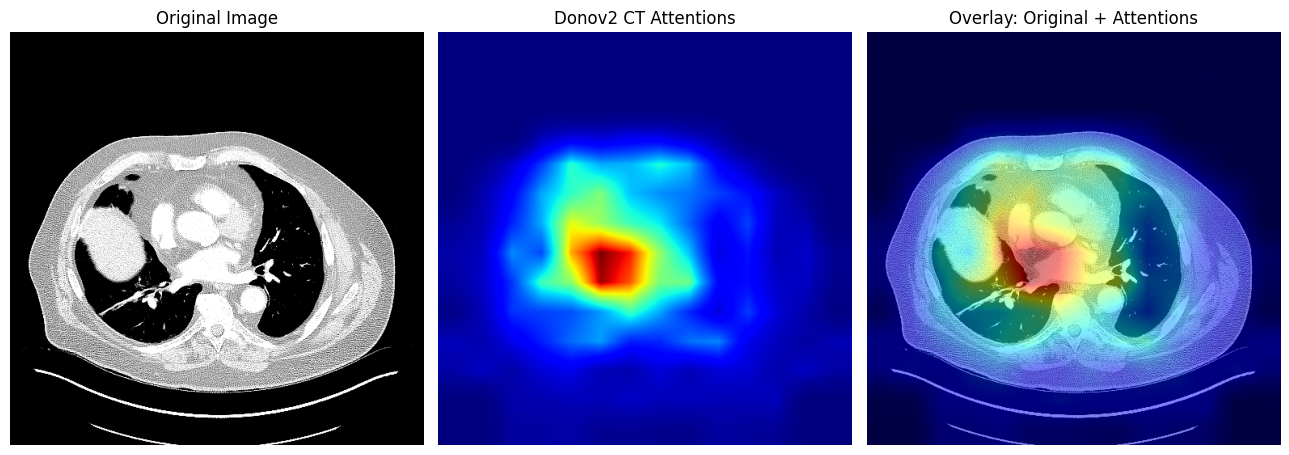

In [13]:
import nibabel as nib
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mean_orspecific_head = "mean" # 4 #"mean" # "mean" or a number"
# Load NIfTI image and extract a slice
# nii_image = nib.load("2.nii").get_fdata()
# image_slice = nii_image[:, :, 176:179]  # Extract slices (175th to 177th, 0-indexed)
# image_slice = nii_image[:, :, 180:183]  # Extract slices (175th to 177th, 0-indexed)

# nii_image = nib.load("1.nii.gz").get_fdata()
# image_slice = nii_image[:, :, 100:103]  # Extract slices (175th to 177th, 0-indexed)

# nii_image = nib.load("3.nii").get_fdata()
# image_slice = nii_image[:, :, 232:235]  # Extract slices (175th to 177th, 0-indexed)

vmin, vmax, eps = -500., 100., 0.00005
#image_slice = np.load("/rsrch7/home/ip_rsrch/wulab/Lung_Foundation_Model_Data_/Batchs_Nii/3SlicesChunks/Batch_1/Chunk1/1013-8771-2564-6281_7_030.npz")
num = 111
root_pathh = "/rsrch7/home/ip_rsrch/wulab/Lung_Foundation_Model_Data_/Batchs_Nii/3SlicesChunks/Batch_1/Chunk1"
file_namee = os.listdir(root_pathh)[num]
file_to_load = os.path.join(root_pathh,file_namee)
image_slice = np.load(file_to_load)
image_slice = image_slice['array']

image_slice = np.array(image_slice, dtype=np.float32)
image_slice = np.clip(image_slice, vmin, vmax )
image_slice = np.clip((image_slice - vmin) / (vmax-vmin), eps, 1-eps)
input_tensor = image_slice.astype(np.float32)
# print(input_tensor.min(),input_tensor.max())
# plt.imshow(input_tensor[:,:,1], cmap="grey")
# plt.show()
print(input_tensor.shape)
#eps = 0.000001
input_array_temp  = np.clip(input_tensor, eps, 1-eps)
# print(input_tensor.min(),input_tensor.max())
# plt.imshow(input_array3[:,:,1], cmap="grey")
# plt.show()
print("input_array_temp.shape",input_array_temp.shape)
w, h = 512, 512
# Convert to (C, H, W)
input_array = np.transpose(input_array_temp, (2, 0, 1))  # (3, 512, 512)

# Convert to PyTorch tensor
input_tensor = torch.from_numpy(input_array)  # (3, 512, 512)

# Resize using interpolate
input_tensor = F.interpolate(
    input_tensor.unsqueeze(0),  # (1, 3, 512, 512)
    size=(448, 448),
    mode='bilinear',
    align_corners=False
).squeeze(0)  # (3, 448, 448)

# Normalize
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)  # (3, 1, 1)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)   # (3, 1, 1)

input_tensor = (input_tensor - mean) / std  # Broadcasting works now
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.to(torch.float32)
print(input_tensor.shape)  # (1, 3, 448, 448)
##########################################################################################################
def get_attention_map(model_ct, x):
    attention_maps = []
    def hook(module, input, output):
        attention_maps.append(output)
    hook_handle = model_ct.blocks[-1][-1].attn.attn_drop.register_forward_hook(hook)
    print(x.shape, x.shape)
    _ = model(x)
    hook_handle.remove()
    return attention_maps[0]
##########################################################################################################
# Get the attention map from the model's last attention layer
with torch.no_grad():
    attn_map = get_attention_map(model_ct, input_tensor.to(device))#input_tensor 1 3 448 448
    print(attn_map.shape)  # Expect torch.Size([1, 12, 790, 790])  
    if mean_orspecific_head=="mean":
        attn_map = attn_map.mean(dim=1)  # Average over all heads   [1, 790, 790]
    else:
        attn_map = attn_map[:,mean_orspecific_head,:,:]    # select the desired head   [1, 790, 790]
    print("After mean over heads:", attn_map.shape) #torch.Size([1, 202, 202]) or [1, 790, 790]
    attn_map = attn_map[0, 6:, 6:]  # Simplified to handle square grids   #448/16=28, 28*28:pathes; 1 class token; 5 register token ==>784+1+5=790
    print("After slicing:", attn_map.shape) # (784,784)
    attn_map = attn_map.mean(dim=0).reshape(n_patch, n_patch) #this line?
attn_map_resized = F.interpolate(attn_map.unsqueeze(0).unsqueeze(0), size=(h, w), mode='bilinear').squeeze()

############################### ############################### ##############################
############################### ############################### ##############################

fig, axes = plt.subplots(1, 3, figsize=(13, 8))

#image1 = np.asarray(original_image)
image2 = attn_map_resized.cpu().numpy()  # Replace with actual data



axes[ 0].imshow(input_array_temp[:,:,1], vmin= 0.0, vmax=0.99, cmap="grey")
axes[0].set_title('Original Image')
axes[ 0].axis('off')

axes[ 1].imshow(image2**3,  cmap='jet')
axes[ 1].set_title('Donov2 CT Attentions')
axes[ 1].axis('off')
print(image2.min(),image2.max())

# Overlay Attention Map on Original Image
axes[2].imshow(input_array_temp[:, :, 1], cmap='gray')  # Base image in grayscale
axes[2].imshow(image2**2, cmap='jet', alpha=0.5)  # Attention map overlay
axes[2].set_title('Overlay: Original + Attentions')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [15]:
14*14, 28*28

(196, 784)

# class token

### blocks[-1] refers to the last BlockChunk, which contains 12 NestedTensorBlock layers.
 you are hooking into blocks[-1], which is a BlockChunk containing 12 NestedTensorBlock layers. 

#### However, when you register a forward hook on a ModuleList (or a custom sequential module like BlockChunk), PyTorch only calls the hook on its final output—meaning the output of the last NestedTensorBlock.

In [20]:
# output[:, 0, :]  #  This extracts the first token from the [1, 790, 768] output.
# Using register_forward_hook → This allows us to capture the output without modifying the model.
# Hooking into model.blocks[-1] → This ensures we get the final representation.
def get_class_token(model, x):
    class_tokens = []
    def hook(module, input, output):
        class_tokens.append(output[:, 0, :])  # Extract the first token ; This extracts the first token from the [1, 790, 768] output.
    hook_handle = model.blocks[-1].register_forward_hook(hook) # Register hook on the last LayerNorm before final output
    _ = model(x)
    hook_handle.remove()
    return class_tokens[0]  # Shape: [1, 768]
##########################################################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    class_token = get_class_token(model_ct, input_tensor.to(device))
    print("Class Token Shape:", class_token.shape)  # Expected: [1, 768]

Class Token Shape: torch.Size([1, 768])


In [21]:
#model_ct

In [22]:
# #!pip install torchinfo
# from torchinfo import summary
# model = model_ct # Replace this with your model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# summary(
#     model_ct, 
#     input_size=(1, 3, 448, 448),  # Batch size of 1, change according to your input shape
#     col_names=["input_size", "output_size", "num_params", "kernel_size"],
#     depth=5  # Controls the level of depth to display in nested modules
# )

In [23]:
# def get_cls_attention_map(model, x):
#     attention_maps = []

#     def hook(module, input, output):
#         attention_maps.append(output)

#     handle = model.blocks[-1][-1].attn.attn_drop.register_forward_hook(hook)
#     _ = model(x)
#     handle.remove()
#     return attention_maps[0]  # [1, 12, 790, 790]

# cls_attention_map = get_cls_attention_map(model_ct, input_tensor.to(device))
# print(cls_attention_map[:, :, 0, :].shape)  # Attention to CLS token


In [24]:
784/28

28.0

In [25]:
448/28

16.0

In [26]:
#!pip install wandb
import wandb

import torch
from functools import partial

# Initialize a W&B run
wandb.init(
    project="my-dinov2-project",  # Name of the W&B project
    entity="my-wandb-entity",     # Your W&B username or team name (optional)
    config={                      # (Optional) Pass in hyperparameters or config
        "img_size": 448,
        "patch_size": 16,
        "drop_path_rate": 0.0,
        "embed_dim": 768,
        "depth": 12,
        "num_heads": 12,
        "mlp_ratio": 4,
        "num_register_tokens": 5
    }
)

checkpoint_path = "/rsrch1/ip/msalehjahromi/codes/dinov2-torchrun-dataloader5/output_dir/448_192_B1to10_B2/eval/training_59999/teacher_checkpoint.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(checkpoint_path, map_location=device)

print(checkpoint.keys())  # Just to inspect what's in your checkpoint

teacher_weights = checkpoint["teacher"]
teacher_weights_cleaned = {
    k.replace("backbone.", ""): v for k, v in teacher_weights.items()
}

# Define your model
model_ct = DinoVisionTransformer(
    img_size=448,
    patch_size=16,
    drop_path_rate=0.0,
    block_chunks=1,
    drop_path_uniform=True,
    embed_dim=768,
    depth=12,
    num_heads=12,
    mlp_ratio=4,
    block_fn=partial(Block, attn_class=MemEffAttention),
    num_register_tokens=5,
    init_values=1.0e-05,
).to(device)

model_ct.load_state_dict(teacher_weights_cleaned, strict=False)
model_ct.eval()


ModuleNotFoundError: No module named 'wandb'

In [27]:
wandb.watch(model_ct, log="all", log_freq=100)


NameError: name 'wandb' is not defined

# PCA

In [28]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def get_patch_embeddings(model, x):
    """
    Forward pass only through PatchEmbed to get patch embeddings.
    model: a DinoVisionTransformer
    x: (torch.Tensor) input image tensor of shape [B, 3, H, W]
    """
    # If your model structure is named similarly to your summary,
    # you can directly call the patch_embed module.
    # PatchEmbed produces shape [B, N, embed_dim].
    with torch.no_grad():
        # If your model's forward function does more than you want,
        # you can directly call model.patch_embed:
        patch_embeds = model.patch_embed(x)  # [B, N, C]
        # Depending on your model, it might produce either [B, embed_dim, h, w]
        # or [B, N, embed_dim]. From your summary, it looks like after the
        # Conv2d, there is a flatten that results in shape [B, N_patches, 768].
        # If it is [B, embed_dim, h, w], you may need to flatten it:
        # patch_embeds = patch_embeds.flatten(2).transpose(1, 2)  # [B, N, C]
    return patch_embeds

def pca_and_threshold_single_image(model, image_tensor, threshold=0.0):
    """
    1) Extract patch embeddings from one image using DINO.
    2) Perform PCA on those embeddings.
    3) Threshold the first principal component to keep only patches > threshold.
    4) Return the patch embeddings, the PCA-transformed embeddings, and the mask.
    model: DinoVisionTransformer
    image_tensor: torch.Tensor of shape [1, 3, H, W]
    threshold: float, threshold on the first PC. Default 0.0 means 'positive values only'.
    """
    model.eval()
    # 1) Get patch embeddings
    patch_embeds = get_patch_embeddings(model, image_tensor)  # [1, N, embed_dim]
    patch_embeds = patch_embeds.squeeze(0).cpu().numpy()      # [N, embed_dim] after squeeze
    # 2) PCA on these patch embeddings
    pca = PCA(n_components=3)  # or 2 or whatever number of PCs you want
    pca_feats = pca.fit_transform(patch_embeds)  # [N, n_components]
    # 3) Threshold on the first principal component
    # The first principal component is pca_feats[:, 0]
    mask = pca_feats[:, 0] > threshold
    return patch_embeds, pca_feats, mask

# Suppose you have a preprocessed image loaded as a torch.Tensor:
# image_tensor shape = [1, 3, 448, 448] on the correct device.
image_tensor = input_tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ct.to(device)
image_tensor = image_tensor.to(device)

with torch.no_grad():
    patch_embeds, pca_feats, mask = pca_and_threshold_single_image(model_ct, image_tensor)

print("Patch embeddings shape:", patch_embeds.shape)   # [N, 768] for example
print("PCA feats shape:", pca_feats.shape)             # [N, 3]
print("Selected patches:", np.sum(mask), "out of", mask.shape[0])


Patch embeddings shape: (196, 768)
PCA feats shape: (196, 3)
Selected patches: 64 out of 196


In [29]:
def visualize_patch_mask(image_pil, mask, patch_size=16):
    """
    Visualize which patches are 'active' (True) after the threshold. 
    mask: a boolean array of shape (N_patches,) 
    patch_size: the resolution of each patch in the original image.
    """
    # Convert mask shape (28*28=784) into (28, 28) for a 448x448 image
    # if the image is indeed 28 patches horizontally and vertically.
    N = int(np.sqrt(len(mask)))  # e.g. 28
    mask_2d = mask.reshape(N, N)
    
    # Create a mask image for visualization
    mask_img = np.zeros((N*patch_size, N*patch_size), dtype=np.uint8)
    for i in range(N):
        for j in range(N):
            if mask_2d[i, j]:
                # Mark those patches in white (255)
                mask_img[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = 255
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(image_pil)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    ax[1].imshow(image_pil, alpha=0.6)
    ax[1].imshow(mask_img, cmap="jet", alpha=0.4)
    ax[1].set_title("Patches above threshold (1st PC)")
    ax[1].axis("off")
    plt.show()

# Example usage:
# image_pil is the PIL Image you used
# visualize_patch_mask(image_pil, mask, patch_size=16)


In [30]:
def multi_image_second_pca(model, image_tensors, threshold=0.0):
    """
    1) For each image, run the first PCA + threshold to keep "foreground" patches.
    2) Collect all retained patches across all images.
    3) Run a second PCA on the combined retained patches.
    
    image_tensors: List of Tensors, each shape [1, 3, H, W].
    Returns:
       combined_pca_feats: PCA results from the second PCA on all retained patches
       second_pca: the PCA object from sklearn
    """
    model.eval()
    
    retained_patches = []
    for img_tensor in image_tensors:
        patch_embeds, pca_feats, mask = pca_and_threshold_single_image(model, img_tensor, threshold=threshold)
        
        # Keep only the patches with positive (or > threshold) first component
        retained_patches.append(patch_embeds[mask])
    
    # 2) Combine all retained patches
    retained_patches = np.concatenate(retained_patches, axis=0)  # shape [Total_retained, embed_dim]
    
    # 3) Perform second PCA
    second_pca = PCA(n_components=3)
    combined_pca_feats = second_pca.fit_transform(retained_patches)
    return combined_pca_feats, second_pca

# Example usage:
# Suppose you have 3 images of the same category:
# image_tensors = [img_tensor1, img_tensor2, img_tensor3]
# combined_pca_feats, second_pca = multi_image_second_pca(model_ct, image_tensors, threshold=0.0)
# print("Shape of second PCA features:", combined_pca_feats.shape)


In [21]:
def demo_pca_procedure(model, image_tensors, patch_size=16, threshold=0.0):
    """
    Demonstration pipeline:
     1. Single-image PCA + threshold for each image.
     2. Visualize the retained patches on the original image.
     3. Second PCA across the retained patches from multiple images.
    """
    retained_patches_list = []
    
    # Single-image PCA for each image
    for i, (img_tensor, img_pil) in enumerate(image_tensors):
        patch_embeds, pca_feats, mask = pca_and_threshold_single_image(model, img_tensor, threshold)
        
        # Visualize
        visualize_patch_mask(img_pil, mask, patch_size=patch_size)
        
        # Collect retained patches
        retained_patches_list.append(patch_embeds[mask])
    
    # Combine all retained patches from the images
    if len(retained_patches_list) > 1:
        all_retained = np.concatenate(retained_patches_list, axis=0)
        second_pca = PCA(n_components=3)
        second_pca_feats = second_pca.fit_transform(all_retained)
        print("Second PCA features shape:", second_pca_feats.shape)
    else:
        print("Only one image provided, skipping second PCA.")

#Example usage:
image_tensors = [
   (img_tensor1, img_pil1),
   (img_tensor2, img_pil2),
   (img_tensor3, img_pil3),
]
demo_pca_procedure(model_ct, image_tensors, patch_size=16, threshold=0.0)
